# Laboratorium 4

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

FIG_EPS = 0.005

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < FIG_EPS:
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


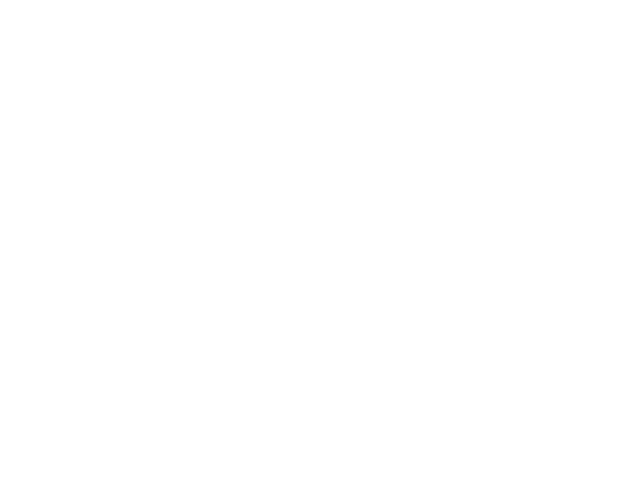

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


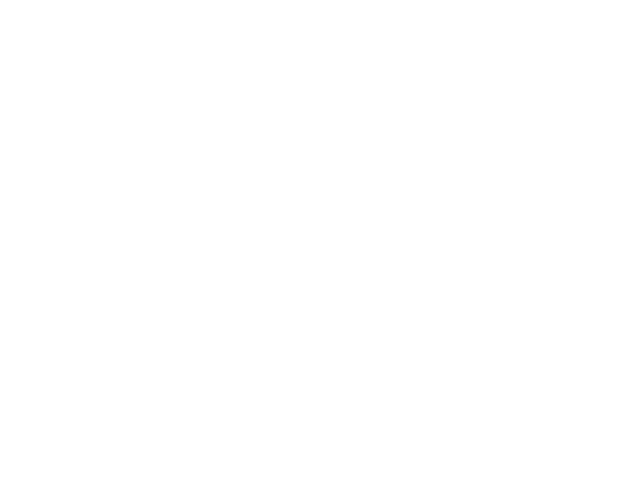

In [4]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


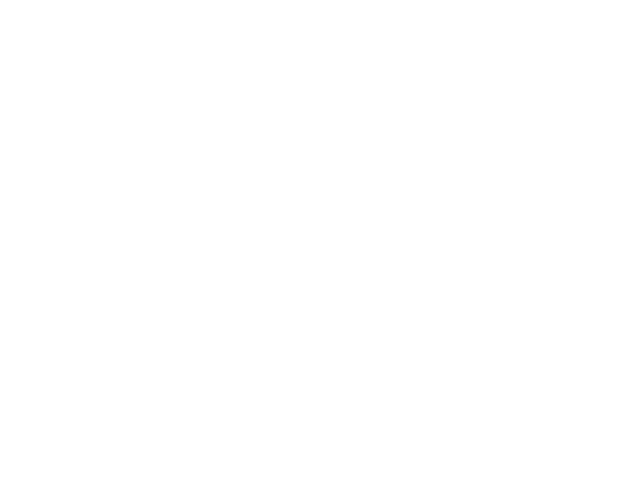

In [5]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


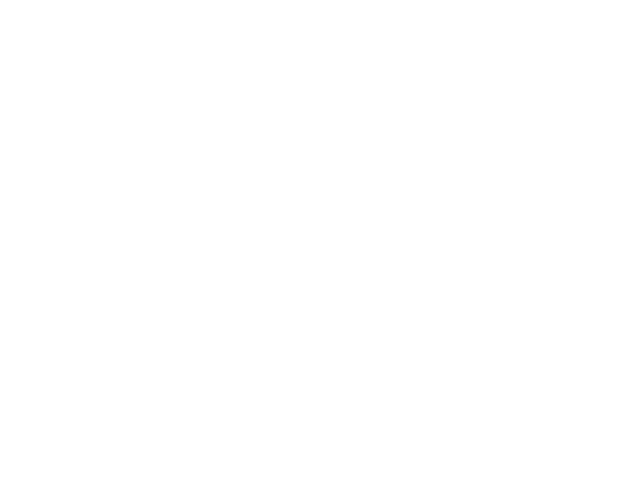

In [6]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

<IPython.core.display.Javascript object>


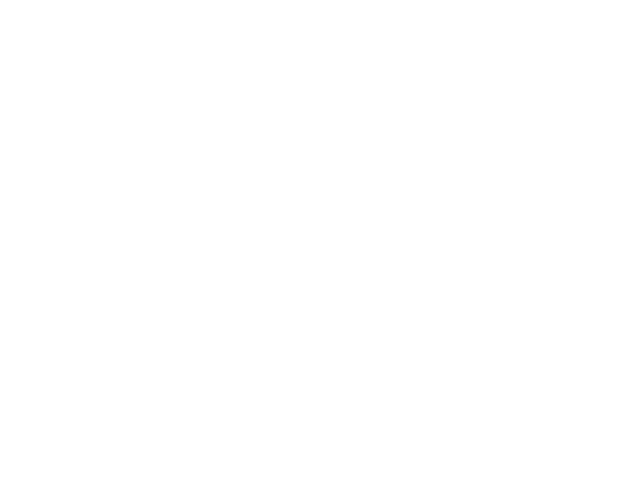

In [7]:
%matplotlib notebook

fig=[]

def tofile(plot, name='somefile.json'):
    with open(name, 'w') as file:
        file.write(plot.toJson())
    
def fromfile(name='somefile.json'):
    with open(name, 'r') as file:
        json = file.read()
    #print(json)
    plot=Plot(json=json)
    fig=js.loads(json)[0]["lines"]
    #print(fig)
    return plot, fig[0]




#tofile(plot2)
plot, fig=fromfile('obecny8.json')
#plot = Plot()
plot.draw()


<IPython.core.display.Javascript object>


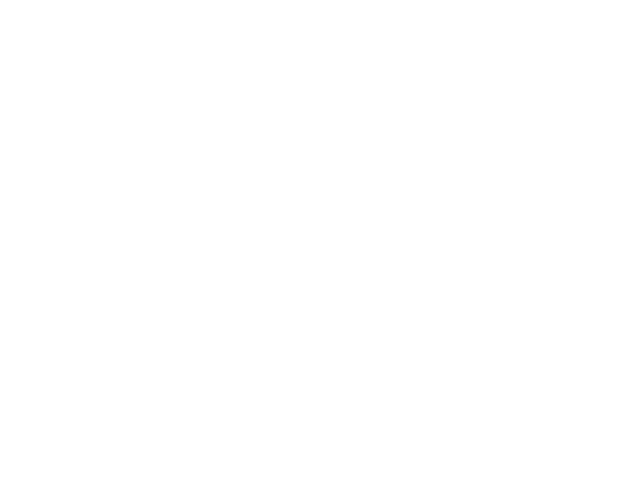

In [8]:
#print(plot.get_added_lines())
plot = Plot([plot.get_added_elements()])
plot.draw()
tofile(plot, 'obecny9.json')

In [9]:
def det(a,b,c):
    #print(a, b, c)
    #return a[0]*b[1]+b[0]*c[1]+c[0]*a[1]-a[1]*b[0]-b[1]*c[0]-c[0]*a[1]
    return (c[0]-a[0])*(b[1]-a[1])-(c[1]-a[1])*(b[0]-a[0])

def collin(x,y,z):
    return min(x[0],y[0]) <= z[0] and z[0] <= max(x[0],y[0]) and min(x[1],y[1]) <= z[1] and z[1] <= max(x[1],y[1])


def intersect(l1, l2):
    
    p1,p2=l1
    p3,p4=l2
    
    d1 = det(p3, p4, p1)
    d2 = det(p3, p4, p2)
    d3 = det(p1, p2, p3)
    d4 = det(p1, p2, p4)

    if ((d1 > 0 and d2 < 0) or (d1 < 0 and d2 > 0)) and ((d3 > 0 and d4 < 0) or (d3 < 0 and d4 > 0)):
        return True

    elif d1 == 0 and collin(p3, p4, p1):
        return True
    elif d2 == 0 and collin(p3, p4, p2):
        return True
    elif d3 == 0 and collin(p1, p2, p3):
        return True
    elif d4 == 0 and collin(p1, p2, p4):
        return True
    else:
        return False
    

In [10]:
def classify(a, b, c):#0 - pocz, 1 - kon, 2 - praw, 3 - lacza, 4 - dziel
    if (a[1]-b[1])*(c[1]-b[1])<0:#2
        return 2
    if a[1]-b[1] > 0:#1 || 3
        if det(a, b, c)<0:
            return 1
        else:
            return 3
    else:#0 || 4
        if det(a, b, c)<0:
            return 0
        else:
            return 4
        

True


<IPython.core.display.Javascript object>


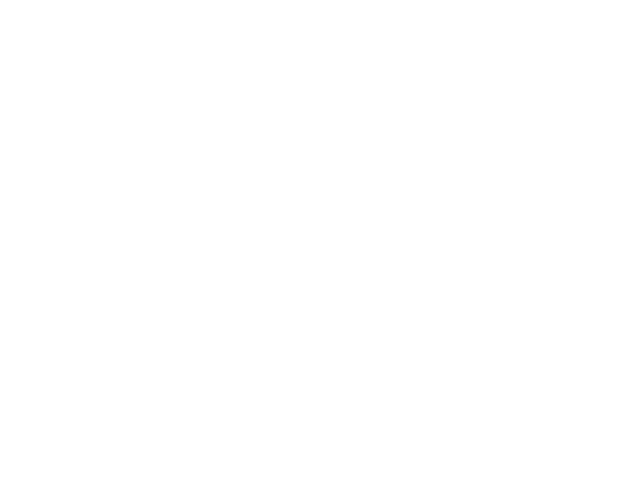

In [11]:
def isymono(fig):
    fig.append(fig[0])
    P=[]
    K=[]
    G=[]
    L=[]
    D=[]
    for i in range(1, len(fig)):
        #print(fig[i])
        cla=classify(fig[i-1][0], fig[i][0], fig[i][1])
        if cla==0:
            P.append(fig[i][0])
        elif cla==1:
            K.append(fig[i][0])
        elif cla==2:
            G.append(fig[i][0])
        elif cla==3:
            L.append(fig[i][0])
        else:
            D.append(fig[i][0])
            
    fig.pop()
    scene=[]
    scene=[Scene([PointsCollection(P, color='lime'),PointsCollection(K, color='red'),PointsCollection(L, color='navy'),PointsCollection(D, color='deepskyblue'),PointsCollection(G, color='brown')],[LinesCollection(fig)])]
    ans=(len(D)+len(L)==0)
    return ans, scene

        
ans, scene=isymono(fig)
print(ans)
plot=Plot(scene)
plot.draw()

In [12]:
def addtriang(a, b, c, triang):
   #addtriang
    triang.append([])
    triang[-1].append([a, b])
    triang[-1].append([b, c])
    triang[-1].append([c, a])
    
def dod(typ, stack, side, i, triang):
    if stack[-1][1]!=typ:
        prev=stack[-1]
        while len(stack)>1:
            addtriang(side[i][0], stack[-1][0], stack[-2][0], triang)
            stack.pop()
        stack.pop()
        stack.append(prev)
        stack.append(side[i])
    else:
        tmp=stack[:]
        stack=[]
        while len(tmp)>1:
            if det(side[i][0], tmp[-1][0], tmp[-2][0])*typ<0:
                addtriang(side[i][0], tmp[-1][0], tmp[-2][0], triang)
                tmp.pop()
            else:
                stack.append(tmp.pop())
        stack.append(tmp.pop())
        stack.reverse()
        stack.append(side[i])
    return stack
    

<IPython.core.display.Javascript object>


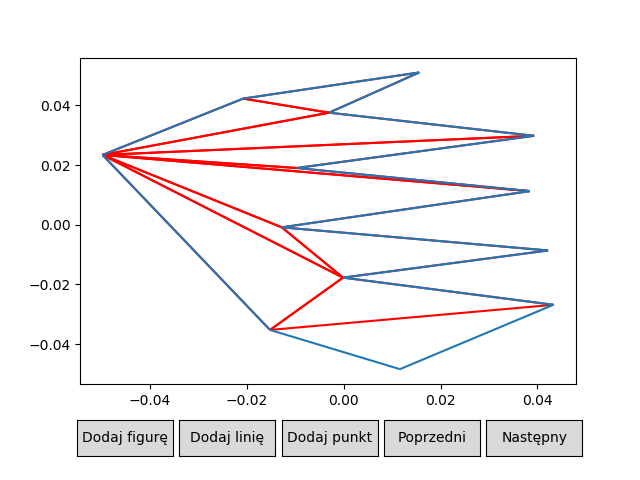

In [15]:
def trian(fig):
    scenes=[]
    topy=[fig[0][0], 0]
    boty=[fig[0][0], 0]
    pkt=[[fig[0][0], 0]]
    for i in range(1,len(fig)):
        if topy[0][1]<fig[i][0][1]:
            topy=[fig[i][0], i]
        if boty[0][1]>fig[i][0][1]:
            boty=[fig[i][0], i]
        pkt.append([fig[i][0], i])
    
    lef=[]
    rig=[]
    
    i=0
    while pkt[(i+topy[1])%len(pkt)]!=boty:
        lef.append([pkt[(i+topy[1])%len(pkt)][0],-1])
        i=i+1
    i=0
    while pkt[(i+topy[1])%len(pkt)]!=boty:
        rig.append([pkt[(i+topy[1])%len(pkt)][0],1])
        i=(i+len(pkt)-1)%len(pkt)
    
    rig.append(boty)
    boty[-1]=-1
    lef.append(boty)
    
    triang=[]
    i=1
    j=1
    stack=[topy+[2], max(lef[1]+[-1], rig[1]+[1], key=lambda x: x[0][1])]
    if lef[1][0][1]<rig[1][0][1]:
        i+=1
    else:
        j+=1
    prev=0
    tmp=[]
    while j<len(lef) and i<len(rig) and lef[j]!=rig[i]:
        ob=[]
        if lef[j][0][1]<rig[i][0][1]:#prawy wyzej
            stack=dod(1, stack, rig, i, triang)
            ob=rig[i][0]
            i+=1
        else:#lewy wyzej
            ob=lef[j][0]
            stack=dod(-1, stack, lef, j, triang)
            j+=1
        
        scenes+=[Scene([PointsCollection([ob], color='pink', marker='o')], [LinesCollection(fig), LinesCollection(tmp[:], color='green')])]
        for x in triang[prev:]:
            scenes+=[Scene([PointsCollection([ob], color='purple', marker='X')], [LinesCollection(fig), LinesCollection(tmp[:], color='green'), LinesCollection(x, color='red')])]
            tmp+=x
        prev=len(triang)
    
    tmp=[]
    for i in triang:
        tmp+=i
    scenes+=[Scene([PointsCollection([])], [LinesCollection(tmp, color='red'), LinesCollection(fig)])]
    
    return scenes


plot, fig=fromfile('obecny8.json')

#plot, fig=fromfile('obecny7.json')
scenes=trian(fig)
plot=Plot(scenes)
plot.draw()